visualize as much as possible using toy data. for gaining intuition on target prop. modeled loosely after http://playground.tensorflow.org/

Visualize...
- preimages
    - of level sets
    - of decision boundaries
    - etc
- images/kernels and their interactions

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
from targprop.datasets import *
from targprop.operations import *

import matplotlib.cm as cm
import matplotlib

In [4]:
mnist = mnist_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
tf.reset_default_graph()

In [6]:
with tf.variable_scope('blahblah', reuse=True) as scope:
  hi = tf.get_variable('hi', shape=[1])

ValueError: Variable blahblah/hi does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?

## toy datasets

In [ ]:
n = 1000

In [ ]:
Xspiral = spiral(n, r=1, s=2.5)

In [ ]:
Xcircs = combine_data((annulus(n/4, d=2, r1=0.1, r2=0.2),
                       annulus(n/4, d=2, r1=0.3, r2=0.4),
                       annulus(n/4, d=2, r1=0.5, r2=0.6),
                       annulus(n/4, d=2, r1=0.7, r2=0.8)))
Xcircs.outputs = np.zeros_like(Xcircs.inputs)
Xcircs.outputs[:n/4,0] = 1
Xcircs.outputs[n/4:2*n/4,1] = 1
Xcircs.outputs[2*n/4:3*n/4,0] = 1
Xcircs.outputs[3*n/4:4*n/4,1] = 1

In [ ]:
Xor = xor_full(n)

In [ ]:
X = Xor
plt.scatter(X.inputs[:,0], X.inputs[:,1], c=un_hotify(X.outputs))
plt.axis('square')
plt.show()

## functions and their inverses

In [ ]:
F = relu()

In [ ]:
x1 = X.inputs
x2 = F.f(x1)
x1_ = F.f_inv(x2, x1, th=0.1)
x1__= F.f_rinv(x2, x1, gamma=1e2)

l = un_hotify(X.outputs)

In [ ]:
plt.scatter(x1[:,0], x1[:,1], c=l)
plt.axis('square')
plt.show()

In [ ]:
plt.scatter(x2[:,0], x2[:,1], c=l)
plt.axis('square')
plt.show()

In [ ]:
plt.scatter(x1_[:,0], x1_[:,1], c=l)
plt.axis('square')
plt.show()

In [ ]:
plt.scatter(x1__[:,0], x1__[:,1], c=l)
plt.axis('square')
plt.show()

In [ ]:
S = sigmoid()

In [ ]:
S.__dict__

In [ ]:
dir(S)

## model

In [ ]:
tf.reset_default_graph()

In [ ]:
### Data
data = Xor
m_dim = data.inputs.shape[1]
p_dim = data.outputs.shape[1]
l_dim = [m_dim] + [3, 2, 3] + [p_dim]
layers = len(l_dim)-1
tf.set_random_seed(1234)
np.random.seed(1234)
b_init = 0
x_in = tf.placeholder(tf.float32, shape=[None, m_dim], name='x_in')
y = tf.placeholder(tf.float32, shape=[None, p_dim], name='y')

In [ ]:
b = (layers+1)*[None]
W = (layers+1)*[None]
L = (layers+1)*[None]
L_inv = (layers+1)*[None]
x1  = (layers+1)*[None]
x2  = (layers+1)*[None]
x3  = (layers+1)*[None]
x1_ = (layers+1)*[None]
x2_ = (layers+1)*[None]
x3_ = (layers+1)*[None]

In [ ]:
V = (layers+1)*[None] # feedback matrix
c = (layers+1)*[None] # feedback bias

In [ ]:
for l in range(1, layers+1):
  with tf.variable_scope('Layer'+str(l)):
    b[l] = tf.get_variable( 'b', shape=[1, l_dim[l]], initializer=tf.constant_initializer(b_init))
    W[l] = tf.get_variable( 'W', shape=[l_dim[l-1], l_dim[l]], initializer=W[l])
    #W[l] = tf.get_variable( 'W', initializer=W[l])
# Feedback graph
for l in range(layers, 1, -1):
  with tf.variable_scope('Layer'+str(l)):
    c[l] = tf.get_variable( 'c', shape=[1, l_dim[l-1]], initializer=tf.constant_initializer(b_init))
    V[l] = tf.get_variable( 'V', shape=[l_dim[l], l_dim[l-1]], initializer=V[l])
    #V[l] = tf.get_variable( 'V', initializer=V[l])

In [ ]:
# forward propagation
nln = tf.tanh
x3[0] = x_in
for l in range(1, layers+1):
  x1[l] = tf.matmul(x3[l-1], W[l], name='x1'+str(l))
  x2[l] = tf.add(x1[l], b[l], name='x2'+str(l))
  if l == layers+1:
    x3[l] = tf.nn.softmax(x2[l], name='x3'+str(l))
  else:
    x3[l] = nln(x2[l], name='x3'+str(l))

In [ ]:
# top layer stuff
L[-1] = tf.reduce_mean(-tf.reduce_sum(y*tf.log(x3[-1]), reduction_indices=[1]), name='global_loss')
x3_[-1] = x3[-1] - alpha*(x3[-1] - y)

In [ ]:
lin = linear()
nln = relu()
add = addition()

In [ ]:
# backward propagation
for l in range(layers, 1, -1):
  if dtp_method==0:
    """vanilla"""
    x2_[l] = tf.matmul(x3_[l], V[l], name='x2_'+str(l))
    x1_[l] = tf.add(x2_[l], c[l], name='x1_'+str(l))
    x3_[l] = nln(x1_[l], name='x3_'+str(l))
  if dtp_method==1:
    """dtp"""
    x3_[l] = tf.sub(x3[l], tf.add(nln(tf.add(tf.matmul(x3[l],  V[l]), c[l])), nln(tf.add(tf.matmul(x3_[l], V[l]), c[l]))), name='x3_'+str(l))
  if dtp_method==2:
    """TODO: np vs tf..."""
    x2_[l]   = nln.f_rinv( x3_[l], x2_[l],         gamma )
    x1_[l]   = add.f_rinv( x2_[l], x1_[l],   b[l], gamma )
    x3_[l-1] = lin.f_rinv( x1_[l], x3_[l-1], W[l], gamma )
    
  

## misc

In [9]:
n1 = 101
ext = 2.0
c = np.linspace(-ext, ext, n1)
x0, y = np.meshgrid(c, c)
x0 = x0.flatten()
y = y.flatten()

gamma = .01

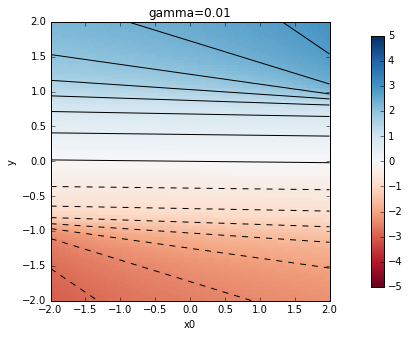

In [ ]:
F = tanh2()
x = F.f_rinv(y[:, np.newaxis], x0[:, np.newaxis], gamma=gamma)
x = x.reshape((x.size))
C = x.reshape((n1,n1))
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ct = ax.contour(x0.reshape((n1,n1)), y.reshape((n1,n1)),C,15,colors='k')
im = ax.imshow(np.flipud(C), cmap=cm.RdBu, interpolation='nearest', vmin=-5, vmax=5, extent=(-ext, ext, -ext, ext))
ax.set_title('gamma='+str(gamma))
plt.colorbar(im,ax=ax, shrink=0.9)
ax.set_xlabel('x0')
ax.set_ylabel('y')
plt.show()

In [ ]:
F = tanh()
x = F.f_rinv(y[:, np.newaxis], x0[:, np.newaxis], gamma=gamma)
#x = F.f_inv(y[:, np.newaxis], x0[:, np.newaxis])
x = x.reshape((x.size))
C = x.reshape((n1,n1))
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ct = ax.contour(x0.reshape((n1,n1)), y.reshape((n1,n1)),C,15,colors='k')
im = ax.imshow(np.flipud(C), cmap=cm.RdBu, interpolation='nearest', vmin=-5, vmax=5, extent=(-ext, ext, -ext, ext))
ax.set_title('gamma='+str(gamma))
plt.colorbar(im,ax=ax, shrink=0.9)
ax.set_xlabel('x0')
ax.set_ylabel('y')
plt.show()

In [242]:
opt = tf.train.RMSPropOptimizer(0.01)

In [ ]:
opt.minimize()

In [188]:
x_0 = np.zeros((100,1))

In [191]:
x_0[0]= 10

In [193]:
x_slice = np.array([[10]])

In [197]:
x_0[5] = x_slice

In [198]:
x_0

array([[ 10.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 10.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  

In [192]:
x_0

array([[ 10.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  